In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

%config InlineBackend.figure_format = 'retina'

# Conclusions

Some conclusions based on data analysis below:

- Users from the following states used the app but didn't buy subscription, so it might be a good idea to review subscription pricing or offer some bonuses for users in this states:
'RI', 'ME', 'AK', 'WA', 'MO', 'LA', 'SC', 'MN', 'SD', 'NE', 'HI', 'MS', 'ID'.
- On the other hand over 65% of all subscribed users come from only two states - CA and TX. So a better strategy might be to focus on this two states.
- There is rapid increase of user activity on the platfom in the period from January to March, but in April user activity has flattened and even started to go down.
- Events that have significant positive correlation with subscription cancellation:

    - Chat Conversation Opened
    - Transaction Refund
    - Chat Conversation Started

- Events that have significant negative correlation with subscription cancellation:
    - Subscription Premium Renew


# Load data

In [2]:
data = pd.read_csv(
    'int20h-ds-test-dataset.csv', 
    parse_dates=['event_created_date'],
)
data.shape

(23357, 8)

In [3]:
data.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [4]:
# event_created_date - is actualy a datetime columns, so let's rename it
data = data.rename(columns={'event_created_date':'event_created_datetime'})

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23357 entries, 0 to 23356
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   userid                  23357 non-null  object        
 1   user_state              23286 non-null  object        
 2   event_name              23357 non-null  object        
 3   event_attributes        23357 non-null  object        
 4   event_created_datetime  23357 non-null  datetime64[ns]
 5   event_platform          23357 non-null  object        
 6   device_manufacture      15847 non-null  object        
 7   device_model            15847 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 1.4+ MB


# Analyze initial raw data

## userid (all users)

In [6]:
print(data.shape[0], '- total records')
print(data.userid.unique().size, '- unique users')

23357 - total records
3540 - unique users


In [7]:
data.userid.value_counts()

627f50253b42607513a1c93bb68201ad    498
dd3c7c5c898a4e6a4ed78d6e2c526bed    257
95e7c959d7d39be0a965e9e315906fed    231
ce84e058130e085513f0455bc725865e    211
31c1e16c643a0b79de9e269ee421a3bb    208
                                   ... 
bcd245e70c8ab2f1fa1388c96e3ff9db      1
3b2a62cad76039c2a4be91f1cdd8a563      1
d28d816d37fb818aae84057acb73920f      1
6fb9389eccb20b461532a8175ae850c2      1
dd0ade014455ca4bddcf4614838709f9      1
Name: userid, Length: 3540, dtype: int64

In [8]:
data.userid.value_counts().describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    3540.000000
mean        6.598023
std        16.822604
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
90%        14.000000
95%        22.000000
max       498.000000
Name: userid, dtype: float64

From the above statistics we get that majority of users made only several actions (over 25% of users have only one record which is useless for predicting subscription cancellation). 
<br>
And only for 5% of users we have more that 22 records. It might be a good idea to exclude these users from the further analysis as outliers. 

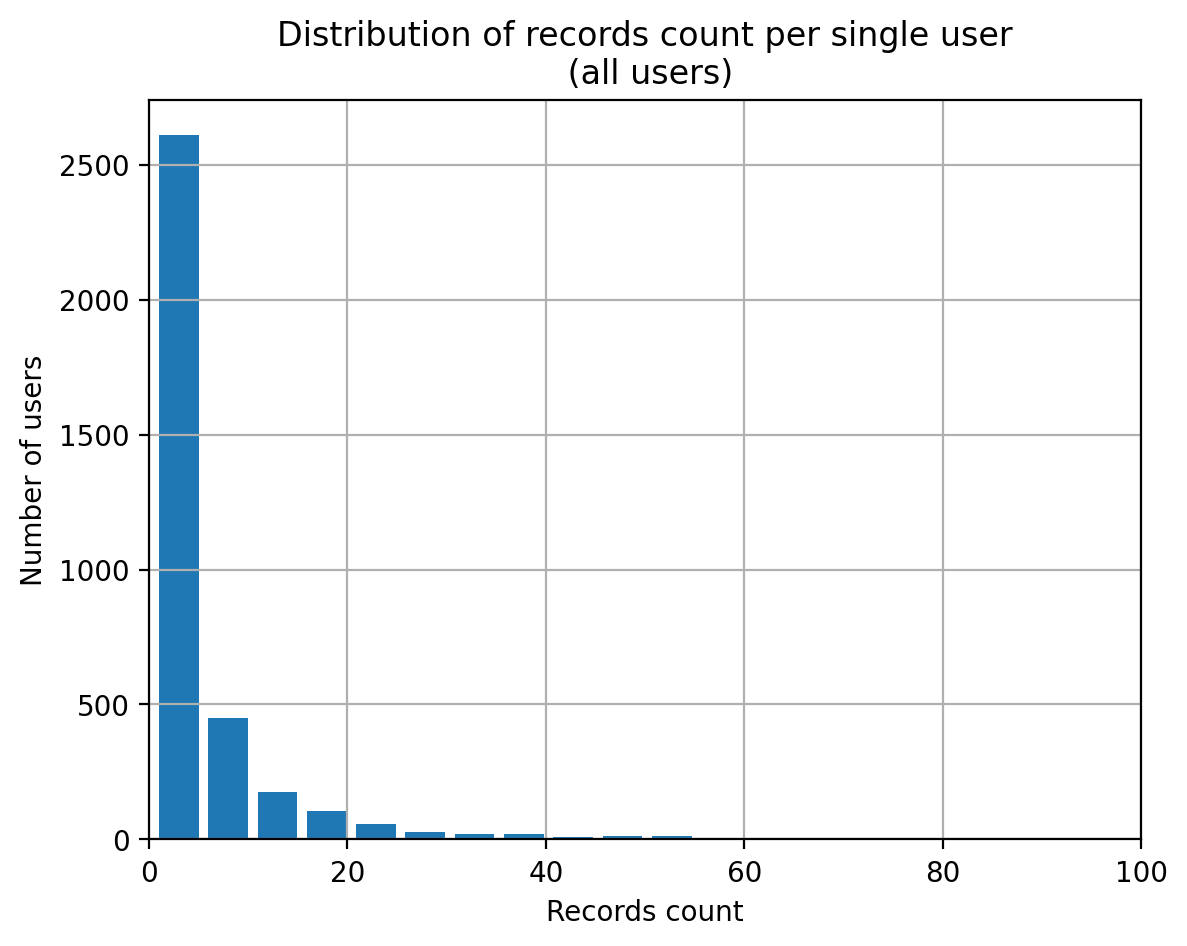

In [9]:
data.userid.value_counts().hist(bins=100, width=4)
plt.title('Distribution of records count per single user\n (all users)')
plt.xlabel('Records count')
plt.ylabel('Number of users')
plt.xlim([0, 100])
plt.show()

## event_name

In [10]:
# Event that we want to predict and prevent
target_event = 'Subscription Premium Cancel'

In [11]:
list(data.event_name.unique())

['Add Vehicle Success',
 'Add Vehicle Break',
 'Calculator View',
 'Add Payment Method Success',
 'Sign Up Success',
 'Add Payment Method Failed',
 'Wallet Opened',
 'Transaction Refund',
 'Email Confirmation Success',
 'Account Setup Skip',
 'Subscription Premium',
 'Chat Conversation Opened',
 'Account Setup Profile Skip',
 'Account History Transaction Details',
 'Sign Out',
 'Chat Conversation Started',
 'Order',
 'Sign Up Error',
 'Subscription Premium Cancel',
 'Calculator Used',
 'Subscription Premium Renew',
 'Add Vehicle Failed',
 'Reset Password Set']

### Events count (for all users)

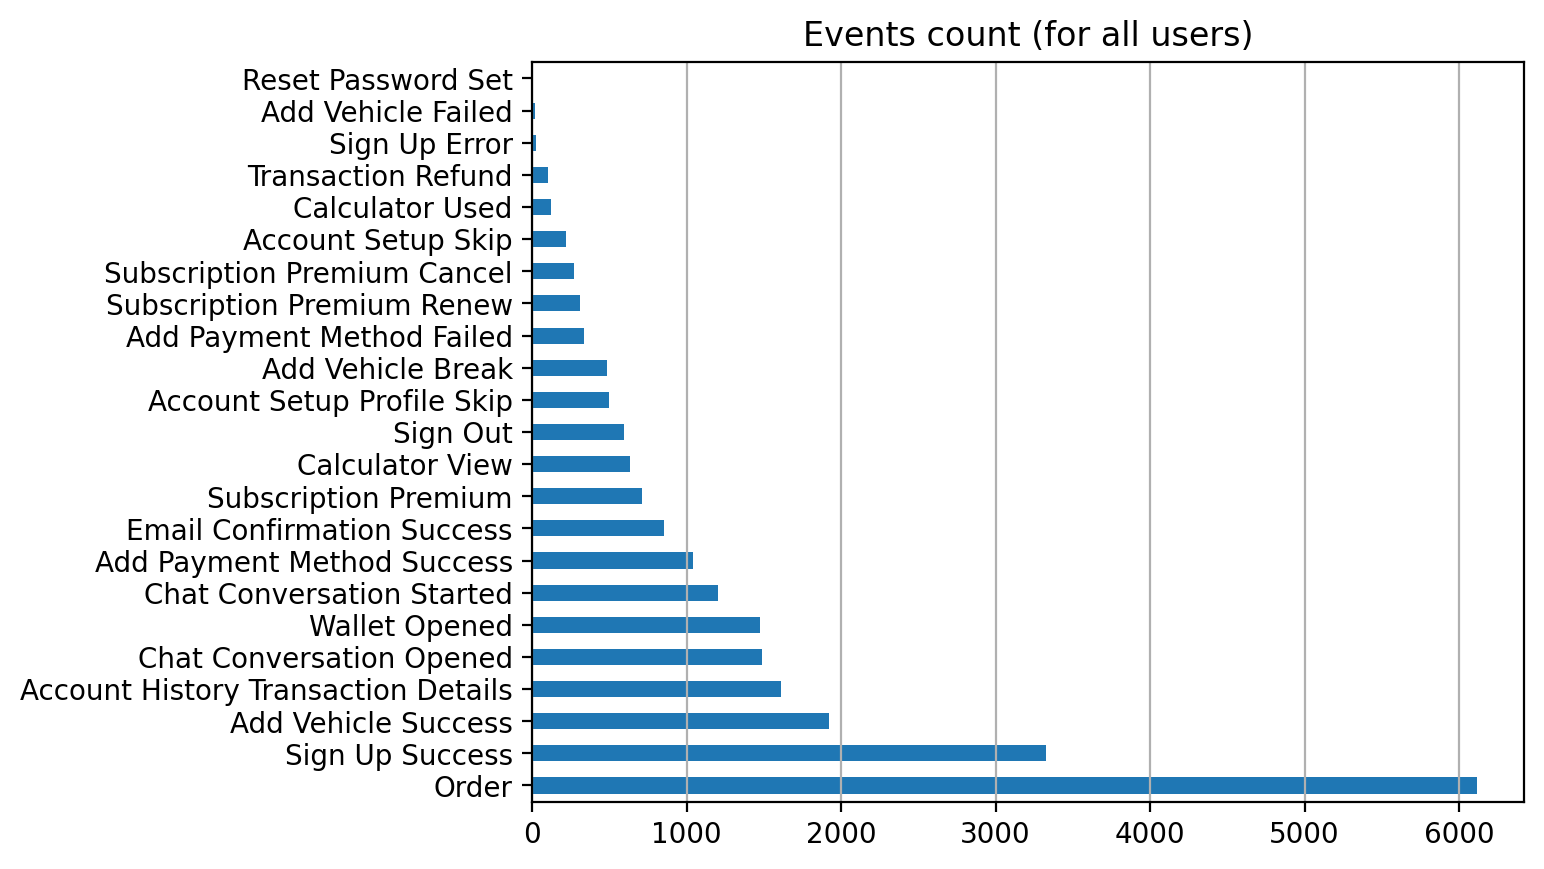

In [12]:
data.event_name.value_counts().plot.barh()
plt.title('Events count (for all users)')
plt.grid(True, axis='x')
plt.show()

Since user cannot cancel subscription without buying it first, and it makes more sence to predict subscription cancellation for users that have one, let's exlude users that don't have `Subscription Premium` event.
<br>
<i>
At the same time let's acknowledge that it also might be useful to analsize users behaviour before they subscribe. For example if there was some issue with the app and user got error or failed operation, you might want to fix that issues and if possible contact that user again.
<br>
But for now let's focus on users who have already subscribed.
</i>

In [13]:
user_subscribed_filter = data.groupby('userid').apply(lambda user: 'Subscription Premium' in user.event_name.values)
user_subscribed_filter

userid
0006869712ec9841dc36234bce245203     True
000a59897372c5e3c147b15685fefc65    False
001244c572f1a681553bc045a378cacf    False
0032cb66b99f6baef57ec2aa04a9277f    False
003f57fe2631ade57a86f6a2b96bb20c    False
                                    ...  
ff9fd3437958123842f3ab75d22fc13f    False
ffa1aa12dd53aee84976cb6c525bb17b    False
ffbbc97af52745060a9dff4eb9917f75    False
ffc566d97935423b6d7a3f9ba211a2b4    False
fffec8d843de9e49ef7c13df5a44da24    False
Length: 3540, dtype: bool

In [14]:
subscribed_users = user_subscribed_filter.index[user_subscribed_filter]
subscribed_users.size

711

In [15]:
# Drop users that never subscribed
data_subs = data[data.userid.isin(subscribed_users)].copy()
data_subs.shape

(12869, 8)

### Events count (for subscribed users)

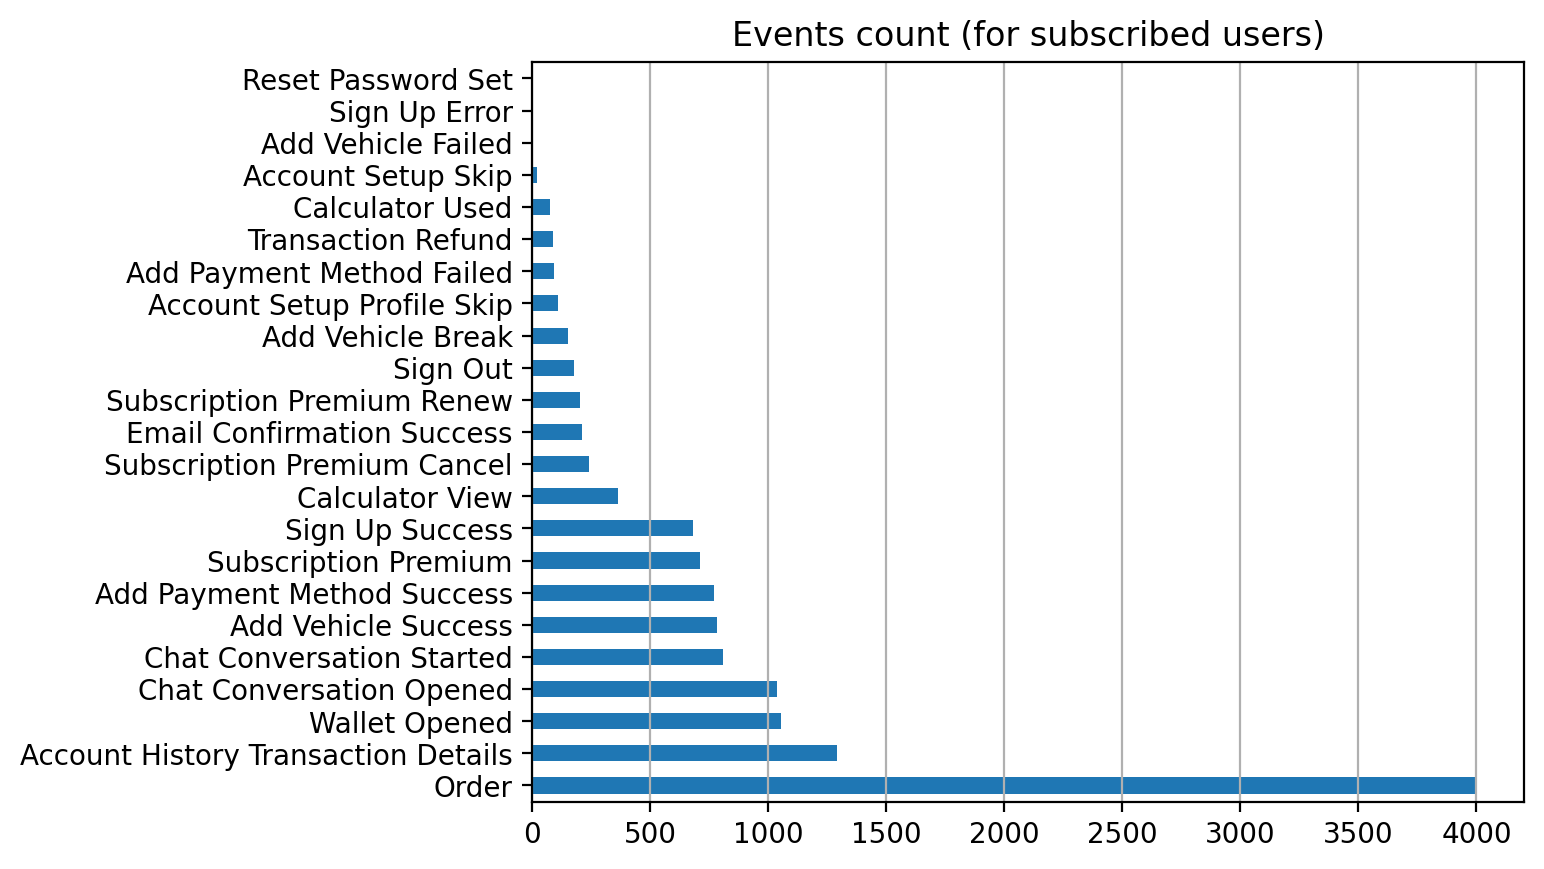

In [16]:
data_subs.event_name.value_counts().plot.barh()
plt.title('Events count (for subscribed users)')
plt.grid(True, axis='x')
plt.show()

## userid (subscribed users)

In [17]:
print(data_subs.shape[0], '- total records')
print(data_subs.userid.unique().size, '- unique users')

12869 - total records
711 - unique users


In [18]:
data_subs.userid.value_counts()

627f50253b42607513a1c93bb68201ad    498
95e7c959d7d39be0a965e9e315906fed    231
ce84e058130e085513f0455bc725865e    211
681be137529c920b3fe7ca9b11001304    183
28368284a145474b2cc4961349bffcf3    157
                                   ... 
cad88df3141ed87ecea0d485a4567161      2
8cd1768507df583eeb41be4549cfc6f2      2
a2e02c36f2999fdcd0f43c7d236f8b98      2
a2d02bb182e368c9841fc45bbea97ad5      2
c0909154a39c165b5929af72634e9a31      1
Name: userid, Length: 711, dtype: int64

In [19]:
data_subs.userid.value_counts().describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    711.000000
mean      18.099859
std       28.585279
min        1.000000
25%        7.000000
50%       11.000000
75%       19.000000
90%       34.000000
95%       50.500000
max      498.000000
Name: userid, dtype: float64

Now distribution of records count is different. 
<br>
Obviously dropping unsubscribed user we dropped all users with only one record (except one user that we'll need to drop seperately).

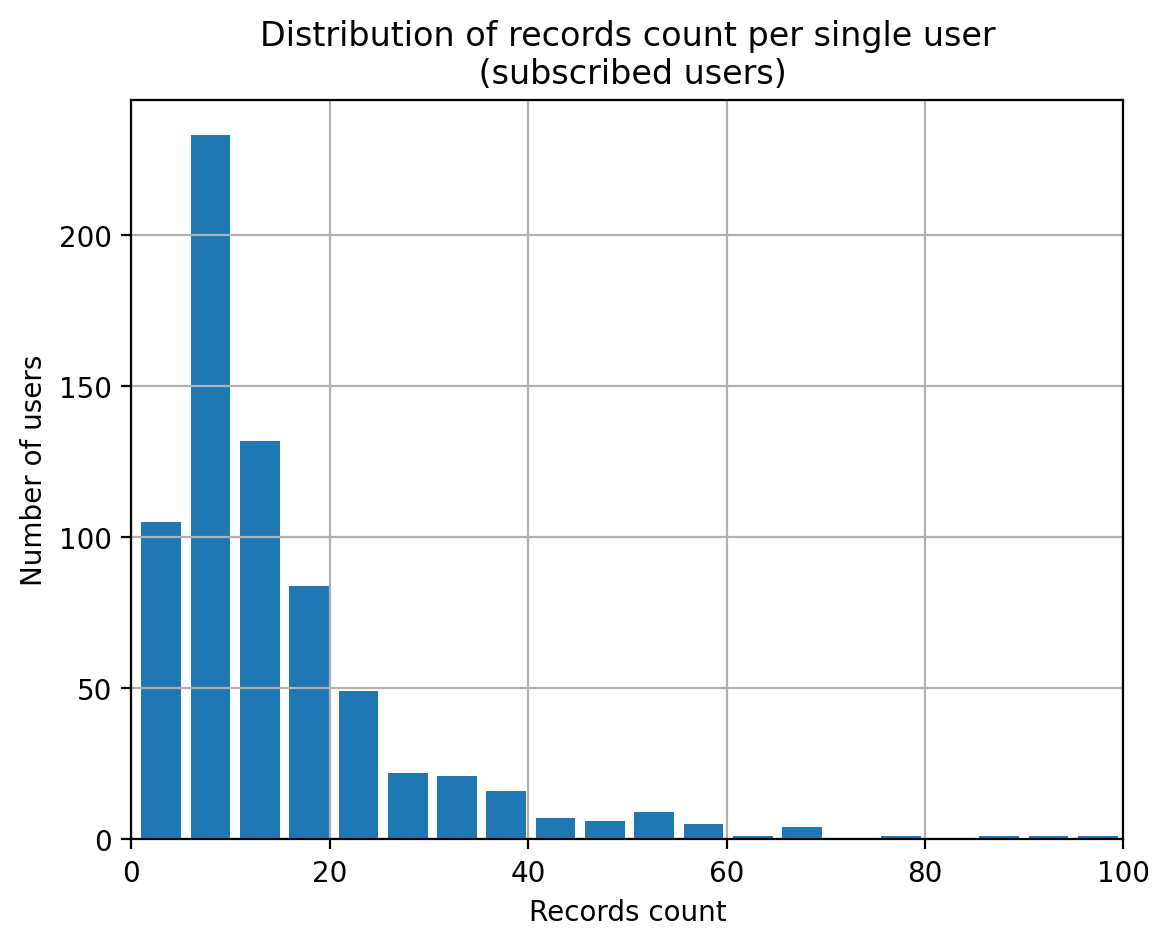

In [20]:
data_subs.userid.value_counts().hist(bins=100, width=4)
plt.title('Distribution of records count per single user\n (subscribed users)')
plt.xlabel('Records count')
plt.ylabel('Number of users')
plt.xlim([0, 100])
plt.show()

## user_state

In [21]:
n_states_all_users = data.user_state.unique().size
n_states_sub_users = data_subs.user_state.unique().size
not_subscribed_states = set(data.user_state.unique()) - set(data_subs.user_state.unique())

print(n_states_all_users, '- Number of states for all users')
print(n_states_sub_users, '- Number of states for subscribed users')
print('States from which users visites platform but not subscribed:')
print(list(not_subscribed_states))

50 - Number of states for all users
36 - Number of states for subscribed users
States from which users visites platform but not subscribed:
['MO', 'HI', nan, 'SD', 'SC', 'ME', 'MN', 'AK', 'WA', 'MS', 'NE', 'ID', 'RI', 'LA']


In [22]:
# Check if there are users with more that 1 unique state
data_subs.groupby('userid').apply(lambda user: user.user_state.unique().size).value_counts()

1    711
dtype: int64

Ok, there are no users that changed their state.
<br>
Let's compare number of users and number of user actions by state.

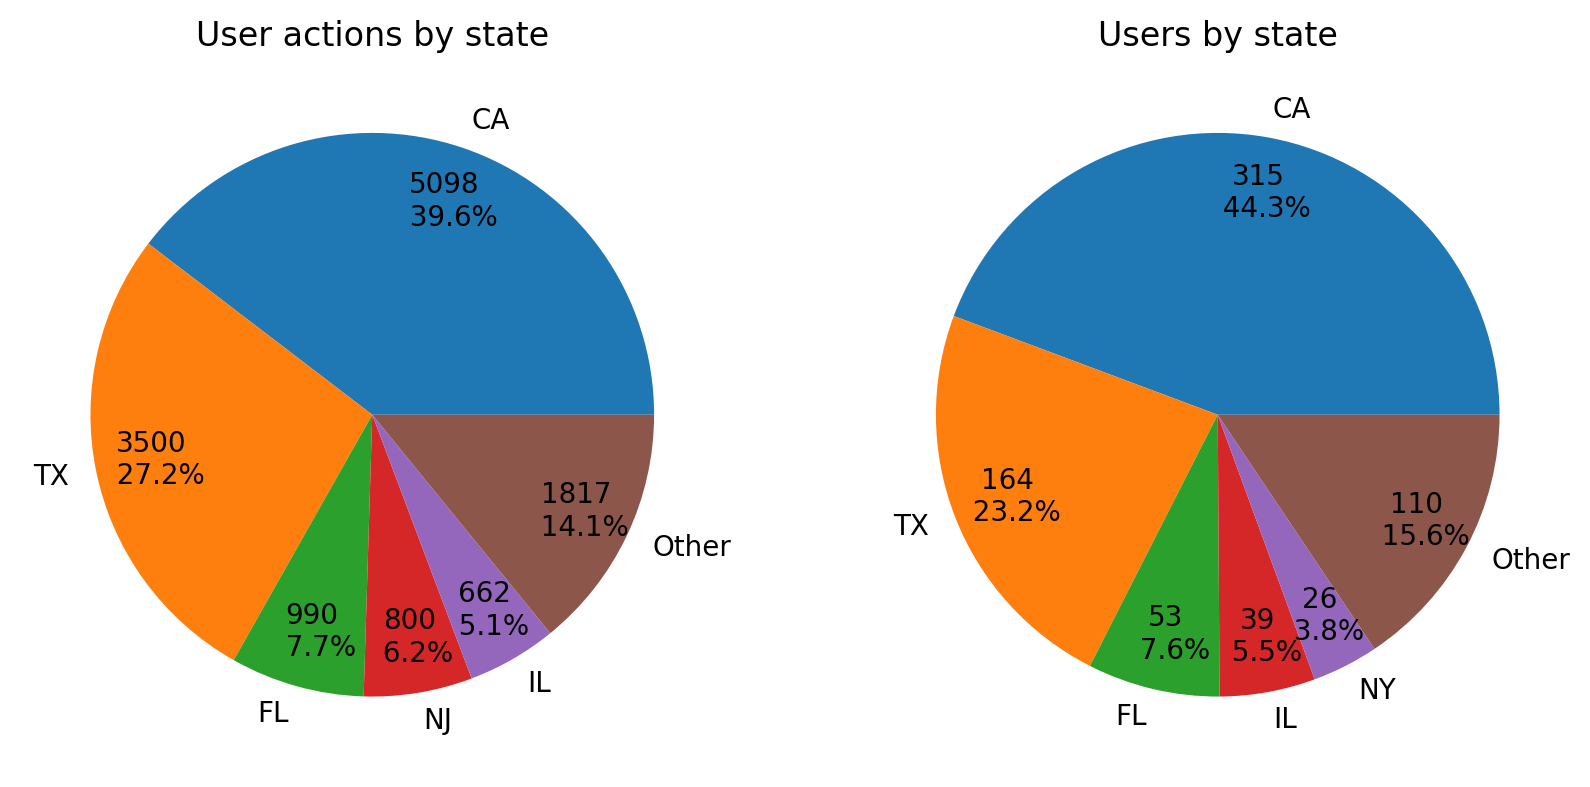

In [23]:
top_n = 5

# User actions
top_action_states = data_subs.user_state.value_counts()[:top_n]
other_action_states = data_subs.user_state.value_counts()[top_n:].sum()

values_action = list(top_action_states.values) + [other_action_states]
labels_action = list(top_action_states.index) + ['Other']
total_action = sum(values_action)

# Users
top_user_states = data_subs.groupby('userid').first().user_state.value_counts()[:top_n]
other_user_states = data_subs.groupby('userid').first().user_state.value_counts()[top_n:].sum()

values_users = list(top_user_states.values) + [other_user_states]
labels_users = list(top_user_states.index) + ['Other']
total_users = sum(values_users)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(
    values_action, 
    labels=labels_action, 
    autopct=lambda pct: "{}\n  {}%".format(
        int(pct / 100 * total_action), 
        round(pct, 1)),
    pctdistance=0.8
)
ax2.pie(
    values_users, 
    labels=labels_users, 
    autopct=lambda pct: "{}\n  {}%".format(
        int(pct / 100 * total_users), 
        round(pct, 1)),
    pctdistance=0.8
)
ax1.set_title('User actions by state')
ax2.set_title('Users by state')
plt.show()

## event_created_date

In [24]:
print(data_subs.event_created_datetime.min().date(), '- earliest date')
print(data_subs.event_created_datetime.max().date(), '- latest date')

2022-01-15 - earliest date
2022-04-16 - latest date


In [25]:
data_subs['event_created_date'] = data_subs.event_created_datetime.dt.date
data_subs['event_created_week'] = data_subs.event_created_datetime.dt.isocalendar().week

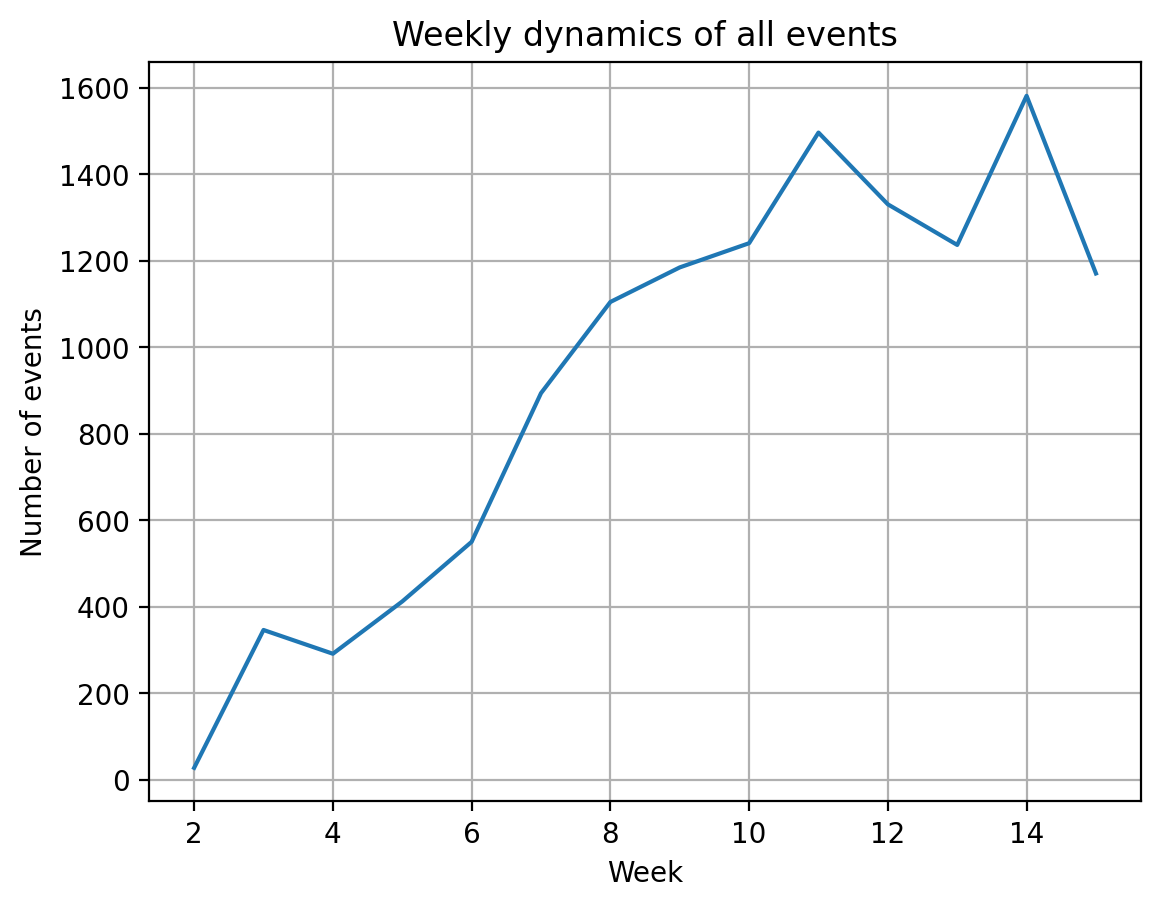

In [26]:
data_subs.groupby('event_created_week').userid.count().plot()
plt.grid(True)
plt.title('Weekly dynamics of all events')
plt.xlabel('Week')
plt.ylabel('Number of events')
plt.show()

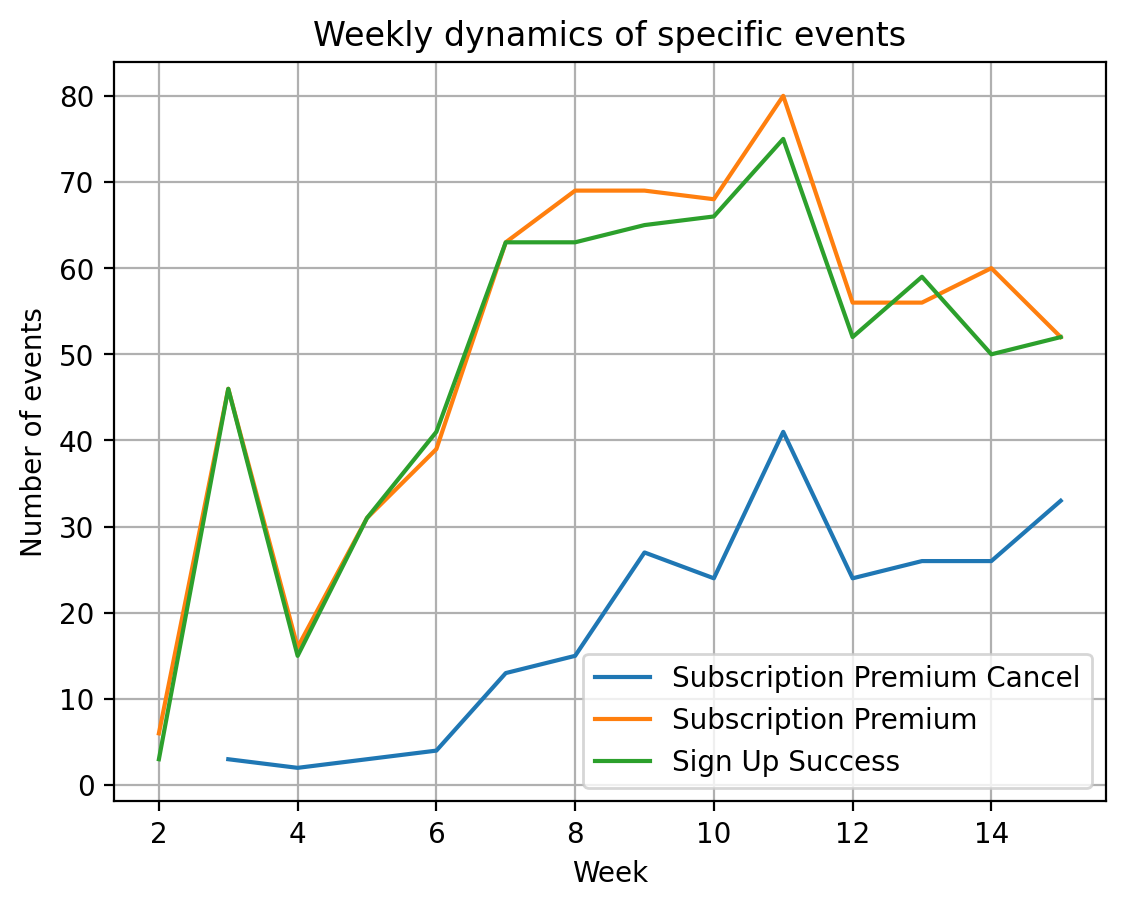

In [27]:
week_col = 'event_created_week'
data_subs[data_subs.event_name == target_event].groupby(week_col).userid.count().plot(label=target_event)
data_subs[data_subs.event_name == 'Subscription Premium'].groupby(week_col).userid.count().plot(label='Subscription Premium')
data_subs[data_subs.event_name == 'Sign Up Success'].groupby(week_col).userid.count().plot(label='Sign Up Success')

plt.title('Weekly dynamics of specific events')
plt.xlabel('Week')
plt.ylabel('Number of events')
plt.grid(True)
plt.legend()
plt.show()

From the "Weekly dynamics" plot we see that events `Sign Up Success` and `Subscription Premium` are almost perfectly aligned. 
<br>
Which might mean that most users that sign up also buy subscription.

## event_attributes

In [28]:
for event_name in list(data_subs.event_name.unique()):
    print(event_name, 'event attributes:')
    print(data_subs[data_subs.event_name == event_name].event_attributes.value_counts()[:5])
    print("_" * 80)

Sign Up Success event attributes:
{"Method":"Google"}      318
{"Method":"Email"}       182
{"Method":"Apple"}       149
{"Method":"Facebook"}     32
Name: event_attributes, dtype: int64
________________________________________________________________________________
Email Confirmation Success event attributes:
{"Required":"true"}    147
{}                      62
Name: event_attributes, dtype: int64
________________________________________________________________________________
Account Setup Skip event attributes:
{}    19
Name: event_attributes, dtype: int64
________________________________________________________________________________
Add Payment Method Success event attributes:
{"Tokenized Pay":"Apple Pay","Payment Method":"Debit","Promo code":""}     114
{"Payment Method":"Debit","Tokenized Pay":"","Promo code":""}               80
{"Payment Method":"Debit","Promo code":""}                                  78
{"Tokenized Pay":"Apple Pay","Payment Method":"Debit"}               

# Event correlations

Calculate user vectors with count of events for each user.

In [29]:
event_frequencies = data_subs.groupby(['userid', 'event_name']).size().unstack(fill_value=0)
event_frequencies.shape

(711, 23)

In [30]:
# Move target event columns to the beginning for convenience
target_freq_col = event_frequencies.pop(target_event)
event_frequencies.insert(0, target_event, target_freq_col)
event_frequencies.head()

event_name,Subscription Premium Cancel,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium,Subscription Premium Renew,Transaction Refund,Wallet Opened
userid,,,,,,,,,,,,,,,,,,,,,,,
0006869712ec9841dc36234bce245203,0,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0
00596aa4edee32815aaf4aad659c484e,0,0,0,0,0,2,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,0,0
007b54670d72df309afd87befcbb63db,0,0,0,0,0,1,1,0,1,0,0,4,1,0,0,0,0,0,1,1,0,0,0
0136a8eeca5d16ac1a521dd0e27ecec0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,2,0,0
01529f53aaba5b512168d432d5650556,0,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [31]:
# Drop 'Subscription Premium' event since all users in current data have subscribed 
event_frequencies = event_frequencies.drop(columns=['Subscription Premium'])
event_frequencies.shape

(711, 22)

In [32]:
event_frequencies[target_event].value_counts()

0    488
1    205
2     18
Name: Subscription Premium Cancel, dtype: int64

In [33]:
event_frequencies.corr().style.background_gradient(cmap='Blues')

event_name,Subscription Premium Cancel,Account History Transaction Details,Account Setup Profile Skip,Account Setup Skip,Add Payment Method Failed,Add Payment Method Success,Add Vehicle Break,Add Vehicle Failed,Add Vehicle Success,Calculator Used,Calculator View,Chat Conversation Opened,Chat Conversation Started,Email Confirmation Success,Order,Reset Password Set,Sign Out,Sign Up Error,Sign Up Success,Subscription Premium Renew,Transaction Refund,Wallet Opened
event_name,,,,,,,,,,,,,,,,,,,,,,
Subscription Premium Cancel,1.000000,0.101961,0.107579,0.056268,-0.026962,0.044263,0.028033,-0.018838,-0.091793,-0.004803,0.043321,0.394768,0.359946,0.010016,-0.096180,-0.024271,0.099354,0.016319,0.027992,-0.169850,0.388795,0.099364
Account History Transaction Details,0.101961,1.000000,0.025044,-0.032266,0.166163,0.189772,0.122019,-0.021682,0.201815,0.134133,0.309877,0.324043,0.362118,-0.012845,0.214944,-0.017091,0.024796,0.009063,0.036519,0.072902,-0.022217,0.566316
Account Setup Profile Skip,0.107579,0.025044,1.000000,0.098350,0.050457,0.057298,0.004510,-0.021825,-0.014801,0.024913,0.058693,0.102133,0.009475,-0.007797,-0.038504,-0.011528,-0.017654,-0.016314,0.022408,-0.089022,0.053989,0.007189
Account Setup Skip,0.056268,-0.032266,0.098350,1.000000,-0.024597,0.027780,0.314107,-0.011184,-0.043439,0.014000,0.031066,0.099609,0.050099,0.077608,-0.034551,-0.005907,0.052876,-0.008360,-0.007902,-0.051591,0.012963,0.013772
Add Payment Method Failed,-0.026962,0.166163,0.050457,-0.024597,1.000000,0.085533,-0.006752,-0.018857,0.090779,-0.031192,0.072850,-0.014774,0.017816,-0.049192,0.020820,0.145683,0.010603,-0.014096,-0.002249,-0.021116,-0.021192,0.056563
Add Payment Method Success,0.044263,0.189772,0.057298,0.027780,0.085533,1.000000,0.049957,-0.013890,0.158517,0.064945,0.186436,0.127742,0.106991,-0.036361,0.130723,-0.007337,-0.001745,-0.010383,0.135297,-0.011118,0.036714,0.293262
Add Vehicle Break,0.028033,0.122019,0.004510,0.314107,-0.006752,0.049957,1.000000,-0.001579,0.112534,-0.016748,0.075346,0.225728,0.133066,0.089099,-0.039043,-0.011817,0.046408,-0.016724,0.044105,-0.066174,0.053798,0.047992
Add Vehicle Failed,-0.018838,-0.021682,-0.021825,-0.011184,-0.018857,-0.013890,-0.001579,1.000000,-0.012777,-0.012222,-0.019663,-0.021287,-0.023114,-0.011549,-0.016523,-0.002667,-0.017651,-0.003774,0.014420,-0.011048,-0.020151,-0.008225
Add Vehicle Success,-0.091793,0.201815,-0.014801,-0.043439,0.090779,0.158517,0.112534,-0.012777,1.000000,0.041246,0.086360,0.046862,0.060195,0.028548,0.064956,-0.006749,-0.013559,-0.058057,0.085921,0.032765,-0.068864,0.108773
